In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ts_inverse.datahandler import get_datasets, ConcatSliceDataset
from torch.utils.data import DataLoader


In [2]:
df_electricity_370 = pd.read_csv("../../data/Electricity370/LD2011_2014_first_40_consumers.csv", index_col='Time', parse_dates=['Time'])
electricity_370_train_datasets, electricity_370_val_datasets, electricity_370_test_datasets = get_datasets("electricity_370", normalize='minmax', columns=df_electricity_370.columns[:1], train_stride=24, observation_days=1, future_days=1, validation_stride=24)
train_dataset = ConcatSliceDataset(electricity_370_train_datasets)
val_dataset = ConcatSliceDataset(electricity_370_val_datasets)
test_dataset = ConcatSliceDataset(electricity_370_test_datasets)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False)


In [3]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the current device
    torch.set_float32_matmul_precision('high')
    device = torch.cuda.current_device()
    print(f"Using CUDA device: {torch.cuda.get_device_name(device)}")
else:
    device = 'cpu'
    print("CUDA is not available")

CUDA is not available


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from opacus import PrivacyEngine
from ts_inverse.models import FCN_Predictor, CNN_Predictor, TCN_Predictor, GRU_Predictor


def train_dp_model(model, tr_dataloader, val_dataloader=None, criterion=F.mse_loss, num_epochs=40, device='cpu', verbose=False, early_stopping=False, patience=3,
                   min_delta=0.005, dp_grad_norm=1.0, dp_delta=1e-5, dp_epsilon=20.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.to(device)
    
    print("Loaded model:", model.name, "to device:", device)

    privacy_engine = PrivacyEngine()
    model, optimizer, tr_dataloader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=tr_dataloader,
        max_grad_norm=dp_grad_norm, # https://opacus.ai/tutorials/building_lstm_name_classifier
        target_delta=dp_delta,
        target_epsilon=dp_epsilon,
        epochs=num_epochs,
    )

    model.train()
    train_loss_history = []
    val_loss_history = []

    print(f"Training {model} model with differential privacy (ε={dp_epsilon}, δ={dp_delta})")

    # Train the model
    for epoch in range(num_epochs):
        for inputs, targets in tr_dataloader:
            inputs, targets = inputs[:, :, model._module.features].to(device), targets[:, :, 0].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        train_loss_history.append(round(loss.detach().item(), 4))

        epsilon = privacy_engine.get_epsilon(dp_delta)
        if val_dataset is not None:
            val_loss = evaluate_model(model, val_dataloader, criterion, device)
            if len(val_loss_history) > 0 and val_loss_history[-1] - val_loss < min_delta or not early_stopping:
                val_loss_history.append(round(val_loss, 4))
            else:
                val_loss_history = []
                val_loss_history.append(round(val_loss, 4))
            if early_stopping and len(val_loss_history) > patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch+1} because validation loss did not improve for {patience} epochs!")
                break

            if verbose:
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss_history[-1]}, Val Loss: {val_loss}, (ε={epsilon}), δ = {dp_delta}")
        elif verbose:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss_history[-1]}, (ε={epsilon}) δ = {dp_delta}")

    model.eval()
    if val_dataset is not None:
        return train_loss_history, val_loss_history
    return train_loss_history


def evaluate_model(model, val_dataloader, criterion=F.mse_loss, device='cpu'):
    model.to(device)
    model.eval()
    val_epoch_losses = []
    for inputs, targets in val_dataloader:
        inputs, targets = inputs[:, :, model._module.features].to(device), targets[:, :, 0].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_epoch_losses.append(loss.detach().item())
    model.train()
    return np.mean(val_epoch_losses)


In [ ]:
from opacus.validators import ModuleValidator

first_model = FCN_Predictor(hidden_size=128, features=[0, 1, 2])
errors = ModuleValidator.validate(first_model, strict=False)
print('Original errors:', errors) # Had to replace the LSTM or GRU with DP version
first_model = ModuleValidator.fix(first_model)
errors = ModuleValidator.validate(first_model, strict=False)
print('Fixed errors:', errors)

Original errors: []


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.nn.modules.container.Sequential was not an allowed global by default. Please use `torch.serialization.add_safe_globals([Sequential])` or the `torch.serialization.safe_globals([Sequential])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
train_loss_history, val_loss_history = train_dp_model(first_model, train_dataloader, val_dataloader, num_epochs=100, device=device, verbose=True, dp_grad_norm=1.0, dp_delta=1e-10, dp_epsilon=20.0)

Loaded model: FCN_Predictor to device: cpu


/home/caspar.meijer/miniconda3/envs/tno_fl_cuda/lib/python3.11/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/home/caspar.meijer/miniconda3/envs/tno_fl_cuda/lib/python3.11/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Training GradSampleModule(FCN_Predictor(
  (input_fc): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (fc): Linear(in_features=128, out_features=96, bias=True)
)) model with differential privacy (ε=20.0, δ=1e-10)


/home/caspar.meijer/miniconda3/envs/tno_fl_cuda/lib/python3.11/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 1/100, Loss: 0.0718, Val Loss: 0.07344174385070801, (ε=2.8524510387664925), δ = 1e-10
Epoch 2/100, Loss: 0.0475, Val Loss: 0.049085021018981934, (ε=3.47441975158178), δ = 1e-10
Epoch 3/100, Loss: 0.0318, Val Loss: 0.03430279716849327, (ε=3.972272429207428), δ = 1e-10
Epoch 4/100, Loss: 0.0212, Val Loss: 0.024730248376727104, (ε=4.403476349281839), δ = 1e-10
Epoch 5/100, Loss: 0.0153, Val Loss: 0.01905108243227005, (ε=4.790936276304128), δ = 1e-10
Epoch 6/100, Loss: 0.0109, Val Loss: 0.015667317435145378, (ε=5.146701738553356), δ = 1e-10
Epoch 7/100, Loss: 0.0079, Val Loss: 0.013580200262367725, (ε=5.478094634755976), δ = 1e-10
Epoch 8/100, Loss: 0.0075, Val Loss: 0.012403990142047405, (ε=5.789983808877198), δ = 1e-10
Epoch 9/100, Loss: 0.0071, Val Loss: 0.011716094799339771, (ε=6.085752743735165), δ = 1e-10
Epoch 10/100, Loss: 0.0076, Val Loss: 0.011306165717542171, (ε=6.367950043201011), δ = 1e-10
Epoch 11/100, Loss: 0.0058, Val Loss: 0.011095868423581123, (ε=6.63846993726076), 

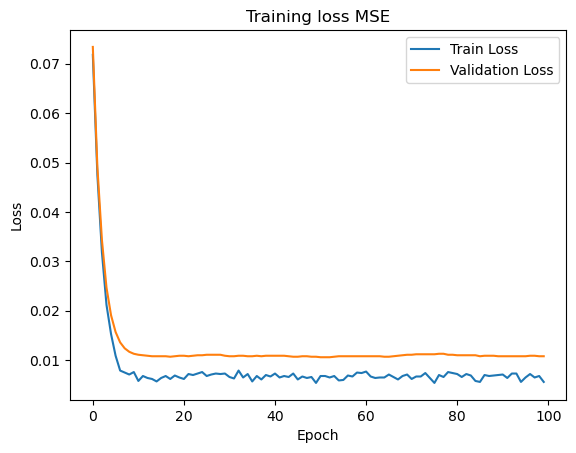

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_loss_history, label='Train Loss')
ax.plot(val_loss_history, label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training loss MSE')
ax.legend()
plt.show()

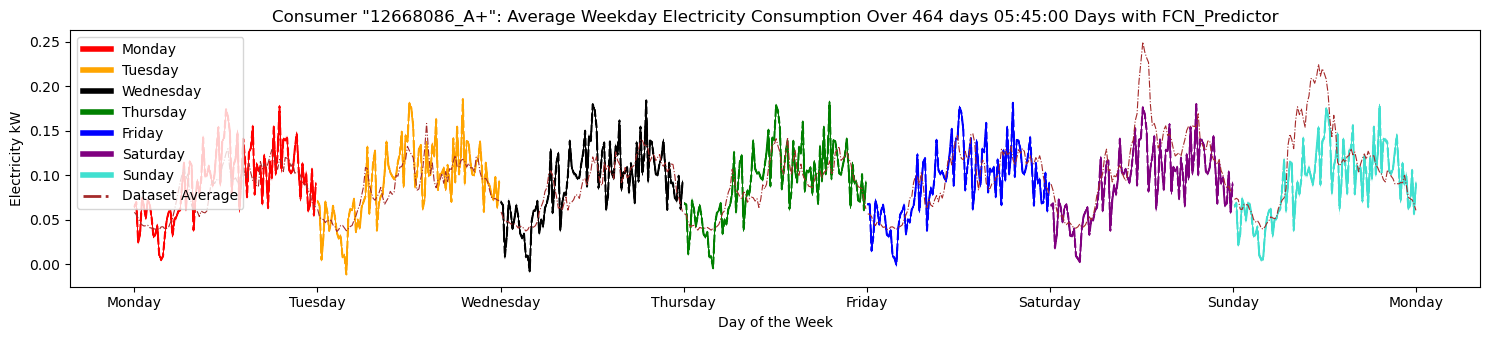

(<Figure size 1500x350 with 1 Axes>,
 <Axes: title={'center': 'Consumer "12668086_A+": Average Weekday Electricity Consumption Over 464 days 05:45:00 Days with FCN_Predictor'}, xlabel='Day of the Week', ylabel='Electricity kW'>)

In [ ]:
plot_train_dataset = electricity_370_train_datasets[0]
plot_train_dataset.plot_weekly_load_profile(verbose=True, model=first_model, device=device)